### 1. Import Libraries and Final Variables

In [3]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import joblib

RANDOM_SEED = 1024
torch.manual_seed(RANDOM_SEED)
DATA_PATH = "../../DATA/new_dataset.csv"
NUM_EPOCHS = 50
BATCH_SIZE = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cpu


### 2. Preprocess Data

In [12]:
# Load File
df = (
    pd.read_csv(DATA_PATH)
      .drop_duplicates()
      .reset_index(drop=True)
)
df.shape

(189647, 378)

In [13]:
# Feature/Label
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
X.shape

(189647, 377)

In [14]:
# Label Encoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [15]:
# Train/Val
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3)

In [8]:
# Test/Val
X_val, X_test, y_val, y_test = train_test_split( X_temp, y_temp, test_size=0.5)
len(X_val)/len(X_test)

0.999964848143982

In [9]:
# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [10]:
# Save
joblib.dump(scaler, 'output/scaler.pkl')
joblib.dump(label_encoder, 'output/label_encoder.pkl')

['label_encoder.pkl']

### 3. Define Dataset

In [ ]:
class SymptomDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_dataset = SymptomDataset(X_train, y_train)
val_dataset = SymptomDataset(X_val, y_val)
test_dataset = SymptomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 4. Define MLP

In [164]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, dropout=0.2):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size

        for hidden_size in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_features = hidden_size

        layers.append(nn.Linear(in_features, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [165]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # fit on train
X_val   = scaler.transform(X_val)         # 同样的变换应用到 val

input_size   = X_train.shape[1]
num_classes  = len(set(y))
hidden_layers = [256, 128]

model = MLP(input_size, hidden_layers, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLP(
  (network): Sequential(
    (0): Linear(in_features=377, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=773, bias=True)
  )
)

### 5. Loss & Optimizer

In [166]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

In [167]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss, model, save_path):
        if val_loss + self.delta < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopper = EarlyStopping(patience=5, delta=1e-5)

### 6. Train

In [168]:
train_losses = []
val_losses   = []
best_val_loss = float('inf')
best_model_path = "output/mlp_disease_model.pth"

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
    epoch_val_loss = val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}  Train Loss: {epoch_train_loss:.4f}  Val Loss: {epoch_val_loss:.4f}")

    if early_stopper(val_loss, model, best_model_path):
        print(f"Validation loss not improve, stop early: (patience={early_stopper.patience})")
        break

Epoch 1/50  Train Loss: 1.7118  Val Loss: 0.6463
Epoch 2/50  Train Loss: 0.6978  Val Loss: 0.5177
Epoch 3/50  Train Loss: 0.6119  Val Loss: 0.4778
Epoch 4/50  Train Loss: 0.5700  Val Loss: 0.4681
Epoch 5/50  Train Loss: 0.5498  Val Loss: 0.4536
Epoch 6/50  Train Loss: 0.5321  Val Loss: 0.4462
Epoch 7/50  Train Loss: 0.5164  Val Loss: 0.4391
Epoch 8/50  Train Loss: 0.5093  Val Loss: 0.4406
Epoch 9/50  Train Loss: 0.5041  Val Loss: 0.4347
Epoch 10/50  Train Loss: 0.4947  Val Loss: 0.4303
Epoch 11/50  Train Loss: 0.4874  Val Loss: 0.4268
Epoch 12/50  Train Loss: 0.4844  Val Loss: 0.4283
Epoch 13/50  Train Loss: 0.4789  Val Loss: 0.4251
Epoch 14/50  Train Loss: 0.4723  Val Loss: 0.4253
Epoch 15/50  Train Loss: 0.4690  Val Loss: 0.4203
Epoch 16/50  Train Loss: 0.4666  Val Loss: 0.4191
Epoch 17/50  Train Loss: 0.4645  Val Loss: 0.4183
Epoch 18/50  Train Loss: 0.4611  Val Loss: 0.4219
Epoch 19/50  Train Loss: 0.4575  Val Loss: 0.4195
Epoch 20/50  Train Loss: 0.4562  Val Loss: 0.4154
Epoch 21/

### 7. Evaluation

In [171]:
model.eval()
y_true = []
y_pred = []

top5_hits = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # Top 1
        _, predicted = outputs.max(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        # Top 5
        _, top5_pred = outputs.topk(5, dim=1)
        hits = (top5_pred == labels.unsqueeze(1)).any(dim=1).sum().item()
        top5_hits += hits
        total += labels.size(0)


accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred,
    average='weighted',
    zero_division=0
)
print(f"Test Acc (Top-1): {accuracy:.4f}")
print(f"Test Precision:    {precision:.4f}")
print(f"Test Recall:       {recall:.4f}")
print(f"Test F1:           {f1:.4f}")

top5_acc = top5_hits / total
print(f"Test Top-5 Accuracy: {top5_acc:.4f}")

Test Acc (Top-1): 0.8246
Test Precision:    0.8413
Test Recall:       0.8246
Test F1:           0.8248
Test Top-5 Accuracy: 0.9719


### 8. Viz

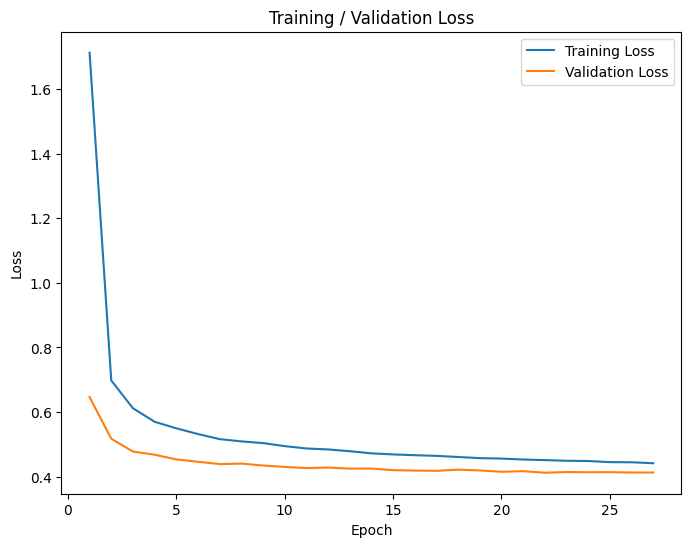

In [172]:
plt.figure(figsize=(8, 6))

epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses[:len(epochs)], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Loss')
plt.legend()
plt.show()